The `load_digits` dataset from the `sklearn.datasets` module provides a set of 8x8 grayscale images of handwritten digits. This dataset is commonly used for classification tasks and serves as an excellent basis for applying image filters, as each image contains clear structural features that are easily highlighted by edge detection and blurring kernels. 

Apply six kernels to 5 images in this dataset from 5 different classes and visualize the resulting feature maps to observe how each kernel emphasizes different visual elements

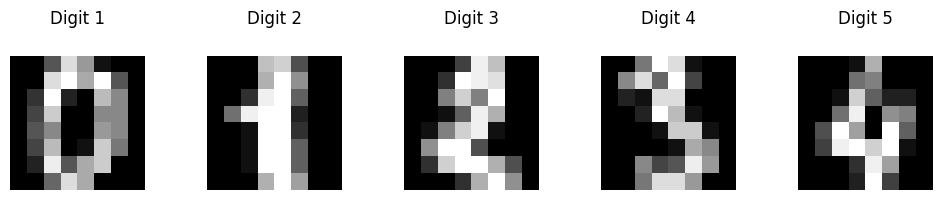

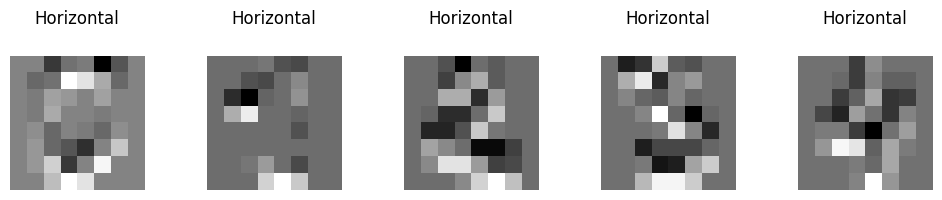

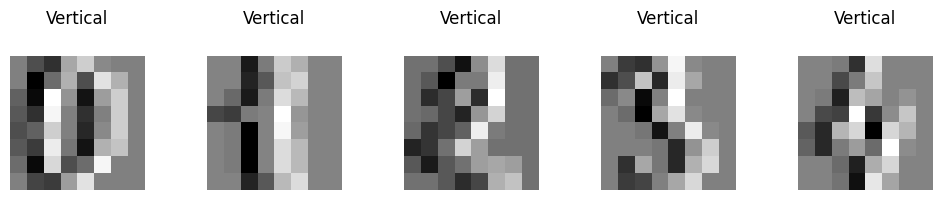

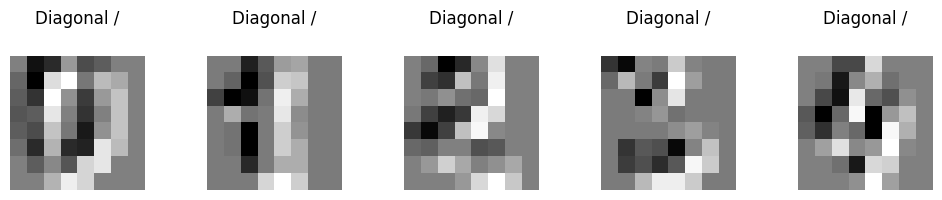

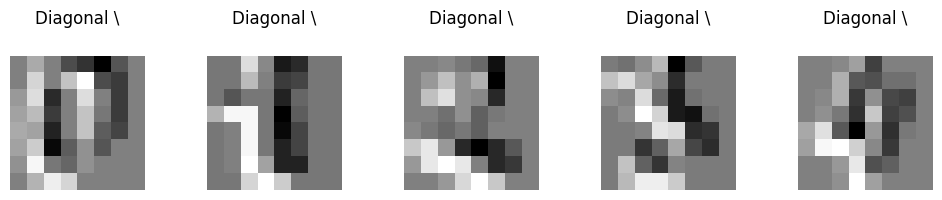

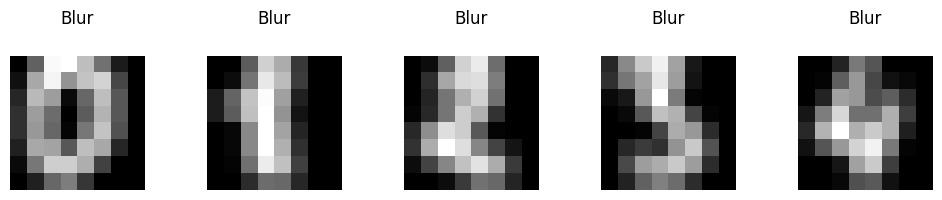

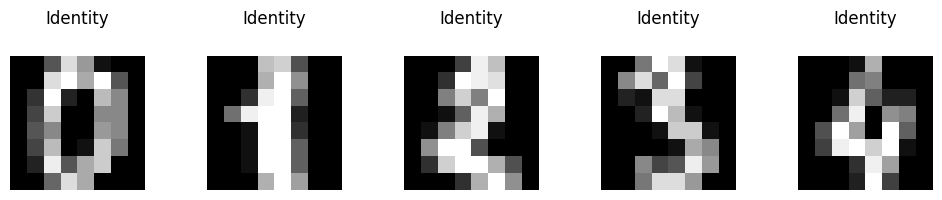

In [ ]:
from sklearn.datasets import load_digits
import torch
import matplotlib.pyplot as plt
import numpy as np

def corr2d(layer, kernel, padding=2):
    k_h, k_w = kernel.shape
    in_h, in_w = layer.shape
    
    # apply padding
    input_matrix= torch.zeros((in_h + padding*2, in_w + padding*2), dtype=torch.float32)
    input_matrix[padding:padding+in_h, padding:padding+in_w] = layer

    in_h += 2*padding
    in_w += 2*padding
    
    out_h = in_h - k_h
    out_w = in_w - k_w
    
    output = torch.zeros((out_h, out_w), dtype=torch.float32)
    
    for i in range(0, out_h):
        for j in range(0, out_w):
            output[i, j] = torch.sum(input_matrix[i:(i + k_h), j:(j + k_w)] * kernel)
    return output[padding:, padding:]

# kernel to filter horizontal edges
hori = torch.tensor([
    [1, 0],
    [-1, 0]
], dtype=torch.float32)
# kernel to filter vertical edges
vert = torch.tensor([
    [1, -1],
    [0, 0]
], dtype=torch.float32)
# kernel to filter diagonal edges (bottom left to top right)
diag1 = torch.tensor([
    [1, 0],
    [0, -1]
], dtype=torch.float32)
# kernel to filter diagonal edges (top left to bottom right)
diag2 = torch.tensor([
    [0, 1],
    [-1, 0]
], dtype=torch.float32)
# kernel to blur the image
blur = torch.tensor([
    [0.25, 0.25],
    [0.25, 0.25]
], dtype=torch.float32)
# identity kernel 
iden = torch.tensor([
    [1, 0],
    [0, 0]
], dtype=torch.float32)

kernel_set = [hori, vert, diag1, diag2, blur, iden]
kernel_name = ["Horizontal", "Vertical", "Diagonal /", "Diagonal \\", "Blur", "Identity"]

# get 5 digits
digits = load_digits()
data = digits.data
labels = digits.target

images = [] # store indices of digit images

plt.figure(figsize=(10, 2))
for c in range(5):
    indices = np.where(labels == c)[0]
    images.append(torch.from_numpy(data[indices[0]].reshape(8,8)))
    plt.subplot(1, 5, c + 1)
    plt.matshow(digits.images[c], cmap='gray', fignum=False)
    plt.title(f"Digit {c+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()
    
convolution = []
# apply each kernel
for kernel, name in zip(kernel_set, kernel_name):
    #fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    outputs = []
    plt.figure(figsize=(10, 2))
    for i in range(5):
        output = corr2d(images[i], kernel)
        outputs.append(output)
        plt.subplot(1, 5, i + 1)
        plt.matshow(output, cmap='gray', fignum=False)
        plt.title(f"{name}")
        plt.axis('off')
    convolution.append(outputs)
    plt.tight_layout()
    plt.show()


Apply pooling operations to feature maps generated using the convolution kernels you defined above to explore how pooling impacts spatial resolution. 

Pooling is typically used to lower the resolution in a convolutional neural network, to balance the increase in feature map channels after convolution.

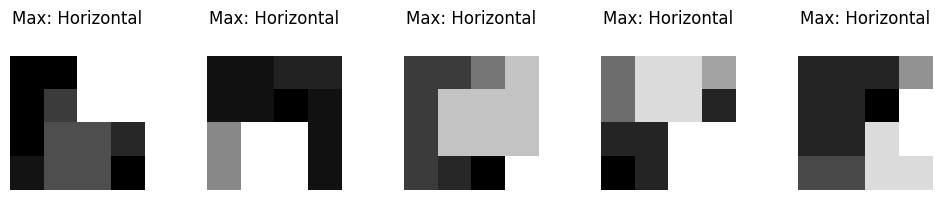

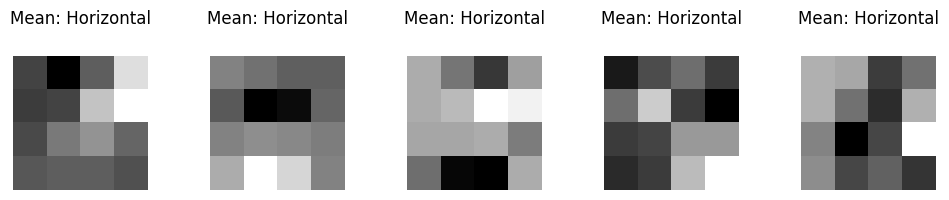

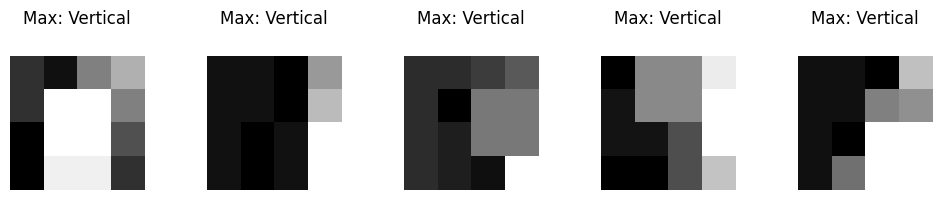

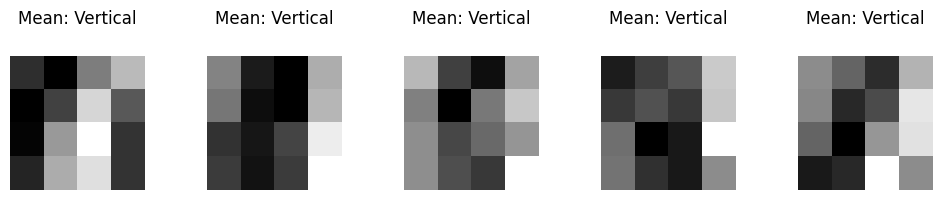

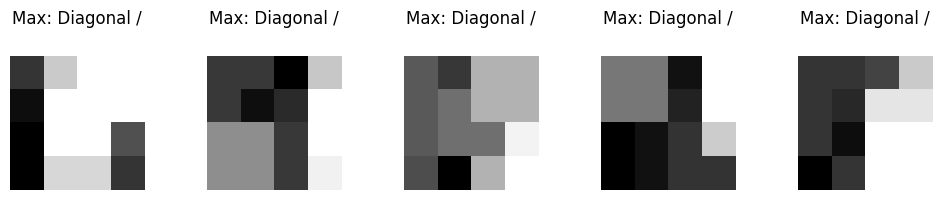

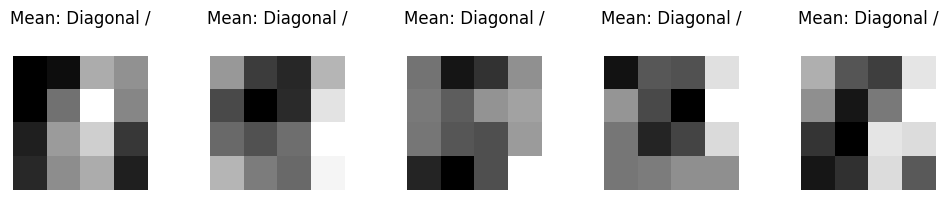

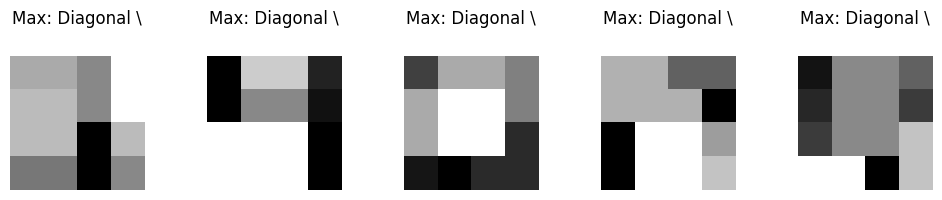

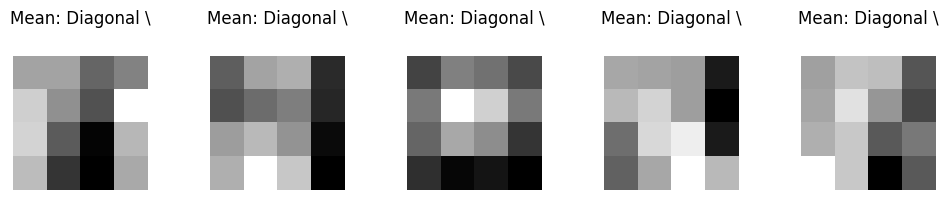

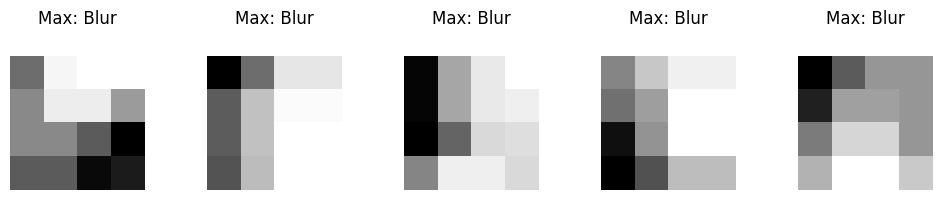

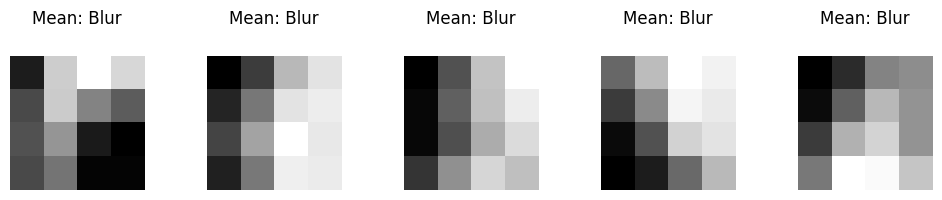

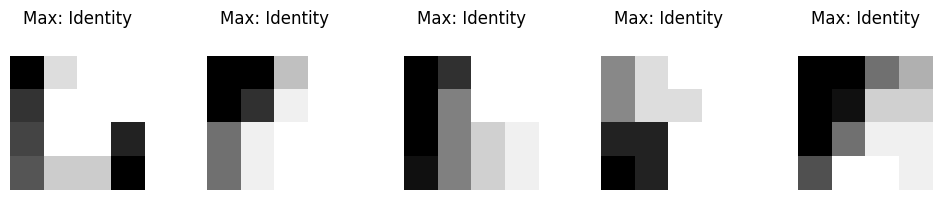

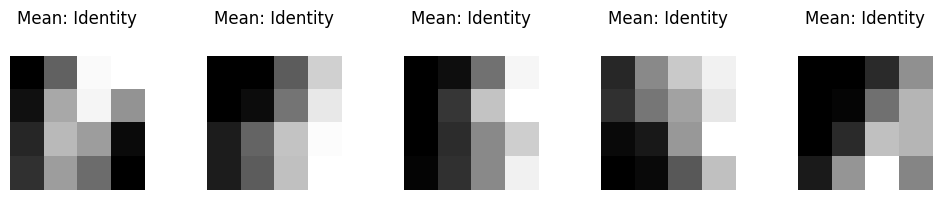

Original Training Example Dimension: 8 , 8
Max Pooled Example Dimension: 4 , 4
Average Pooled Example Dimension: 4 , 4


In [ ]:
# mode=0 max-pooling, mode=1 average-pooling
def pool2d(layer, window_size, mode=0):
    win_h, win_w = window_size
    in_h, in_w = layer.shape

    out_h = int(in_h / win_h)
    out_w = int(in_w / win_w)

    if mode == 0: # max pooling
        output = torch.stack([torch.max(layer[i:i+win_h, j:j+win_w])
                    for i in range(0, out_h) for j in range(0, out_w)]).reshape(out_h, out_w)
    else: # average pooling
        output = torch.stack([torch.mean(layer[i:i+win_h, j:j+win_w])
                    for i in range(0, out_h) for j in range(0, out_w)]).reshape(out_h, out_w)
    return output
        
max_pool = []
ave_pool = []

for i in range(6):
    max_outputs = []
    plt.figure(figsize=(10, 2))
    for j in range(5):
        output = pool2d(convolution[i][j], (2,2), 0)
        max_outputs.append(output)
        plt.subplot(1, 5, j + 1)
        plt.matshow(output, cmap='gray', fignum=False)
        plt.title(f"Max: {kernel_name[i]}")
        plt.axis('off')
    max_pool.append(max_outputs)
    plt.tight_layout()
    plt.show()
    
    ave_outputs = []
    plt.figure(figsize=(10, 2))
    for j in range(5):
        output = pool2d(convolution[i][j], (2,2), 1)
        ave_outputs.append(output)
        plt.subplot(1, 5, j + 1)
        plt.matshow(output, cmap='gray', fignum=False)
        plt.title(f"Mean: {kernel_name[i]}")
        plt.axis('off')
    ave_pool.append(ave_outputs)
    plt.tight_layout()
    plt.show()
    
        
print("Original Training Example Dimension:", convolution[0][0].shape[0], ",", convolution[0][0].shape[1])        
print("Max Pooled Example Dimension:", max_pool[0][0].shape[0], ",", max_pool[0][0].shape[1])        
print("Average Pooled Example Dimension:", ave_pool[0][0].shape[0], ",", ave_pool[0][0].shape[1])        

Build a Convolutional Neural Network using the PyTorch library. Implement a CNN with an initial convolutional layer with 8 filters of size 3x3, padding set to 1, followed by a `ReLU` activation function.

A second convolutional layer with 3 filters of size 3x3, again with padding 1 and followed by `ReLU` activation function.

A max pooling layer with a 2x2 kernel to downsample the features.

A fully connected layer with 120 units, followed by another fully connected layer with 84 units.

The output layer should have 10 units for classification (one for each digit from 0 to 9). 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=3, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(3 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:58<00:00,  2.39it/s]


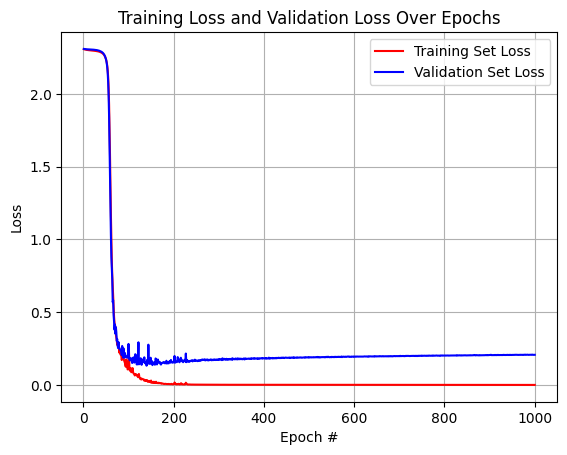

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# preprocess data
digits = load_digits()
data = digits.data / 16
labels = digits.target

data = data.reshape(-1, 1, 8, 8)

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(data, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long) 
    
# divide up the data
X_tensor, X_test, y_tensor, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_tensor, y_tensor, test_size=0.5)

train_set = TensorDataset(X_train, y_train)
valid_set = TensorDataset(X_valid, y_valid)
test_set = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

model = CNN()
loss_func = nn.CrossEntropyLoss()  # includes softmax
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

num_epochs = 1000
train_loss = np.zeros(num_epochs)
valid_loss = np.zeros(num_epochs)
# Establish checkpoint
checkpoint = {
        'loss': float('inf')  # Save the current loss
    }

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    for data, target in train_loader:
        optimizer.zero_grad()
        # Calculate loss
        loss = loss_func(model(data), target)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss[epoch] += loss.item()
    
    train_loss[epoch] /= len(train_loader)
    
    # Validation loss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradient computation during evaluation
        for data, target in valid_loader:
            valid_loss[epoch] += loss_func(model(data), target).item()
    valid_loss[epoch] /= len(valid_loader)

    if valid_loss[epoch] < checkpoint["loss"]:
        checkpoint = {
        'model_state_dict': model.state_dict(),  # Save model parameters
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state
        'loss': loss  # Save the current loss
        }

# Test loss
model.load_state_dict(checkpoint['model_state_dict'])  # Load model parameters
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Load optimizer state
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No gradient computation during evaluation
    for data, target in test_loader:
        _, predicted = torch.max(model(data), 1)
        correct += (predicted == target).sum().item()
        total += len(target)
cnn_accuracy = correct / total

# Plot training loss and validation loss over epochs
plt.plot(range(1, num_epochs + 1), train_loss, label="Training Set Loss", color="red")
plt.plot(range(1, num_epochs + 1), valid_loss, label="Validation Set Loss", color="blue")
plt.title("Training Loss and Validation Loss Over Epochs")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Compare the classification performance of your Convolutional Neural Network (CNN) to a traditional Support Vector Classifier (SVC) on the `load_digits` dataset from `sklearn`.

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
# split the data
digits = load_digits()
data = digits.data / 16
labels = digits.target

# divide up the data
data, X_test, labels, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.5, random_state=42)

svm = SVC(gamma=0.001)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("CNN Accuracy :", cnn_accuracy * 100, "%")
print("SVM Accuracy:", np.sum(y_test == y_pred) / len(y_test) * 100, "%")

CNN Accuracy : 95.0 %
SVM Accuracy: 18.88888888888889 %


The CNN worked better than the SVM model. This is because the CNN encompasses spatial locality and translation invariance of features through convolution and pooling layers. Whereas the SVM model treats each pixel as a separate feature and doesn't consider the spatial relations between nearby pixels and will have difficulty identifying larger structures in the image. Differing weights over input nodes makes the SVM unable to identify features with translation invariance. So it is sensitive to misclassification on test examples that deviate by small translations from training examples. To improve SVM, we would need to preprocess the input before training by creating input features that represent small sections of the image (simulate pooling) and measure whether a visual features is present in the image in that region (manually perform feature extraction).